In [1]:
# preload dataset automatically, if not already in place.
import os
from pathlib import Path
from pprint import pprint
import numpy as np
import pandas as pd

def download_file_from_gdrive(file_url, filename, out_path: Path, overwrite=False):
    """
    Downloads a file from GDrive given an URL
    :param file_url: a string formated as https://drive.google.com/uc?id=<file_id>
    :param: the desired file name
    :param: the desired folder where the file will be downloaded to
    :param overwrite: whether to overwrite the file if it already exists
    """
    file_exists = os.path.exists(f'{out_path}/{filename}')

    if (file_exists and overwrite) or (not file_exists):
        os.system(f'gdown {file_url} -O {out_path}/{filename}')

In [10]:
FILE_URL = "https://drive.google.com/uc?id=1N8eav5HWd6A7rG0ZCRo7rNFryqZS4tVg"
FILE_NAME = "renthop_train.json.gz"
DATA_PATH = Path("C://Users//mateu//mlcourse.AI//Topic06//data")

download_file_from_gdrive(file_url=FILE_URL, filename= FILE_NAME, out_path=DATA_PATH)

df = pd.read_json(DATA_PATH / FILE_NAME, compression="gzip",
                  convert_dates=['created'])

<h3>Texts<h3>

Bag of Words approach: we create a vector with the length of the vocabulary, compute the number of occurrences of each word in the text, and place that number of occurrences in the appropriate position in the vector.

In [11]:
texts = ["i have a cat", "you have a dog", "you and i have a cat and a dog"]

vocabulary = list(
    enumerate(set([word for sentence in texts for word in sentence.split()]))
)
print("Vocabulary:", vocabulary)


def vectorize(text):
    vector = np.zeros(len(vocabulary))
    for i, word in vocabulary:
        num = 0
        for w in text:
            if w == word:
                num += 1
        if num:
            vector[i] = num
    return vector


print("Vectors:")
for sentence in texts:
    print(vectorize(sentence.split()))

Vocabulary: [(0, 'a'), (1, 'i'), (2, 'cat'), (3, 'and'), (4, 'have'), (5, 'dog'), (6, 'you')]
Vectors:
[1. 1. 1. 0. 1. 0. 0.]
[1. 0. 0. 0. 1. 1. 1.]
[2. 1. 1. 2. 1. 1. 1.]


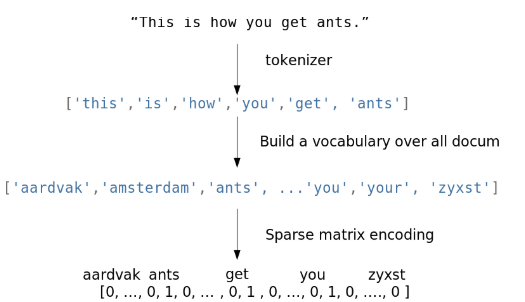

When using algorithms like Bag of Words, we lose the order of the words in the text,
<br>which means that the texts “i have no cows” and “no, i have cows” will appear identical after vectorization when,
<br>in fact, they have the opposite meaning. 
<br>To avoid this problem, we can revisit our tokenization step and use N-grams (the sequence of N consecutive tokens) instead.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 1))
vect.fit_transform(["no i have cows", "i have no cows"]).toarray()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [13]:
vect.vocabulary_

{'no': 2, 'have': 1, 'cows': 0}

In [14]:
vect = CountVectorizer(ngram_range=(1, 2))
vect.fit_transform(["no i have cows", "i have no cows"]).toarray()

array([[1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 0]], dtype=int64)

In [15]:
vect.vocabulary_

{'no': 4,
 'have': 1,
 'cows': 0,
 'no have': 6,
 'have cows': 2,
 'have no': 3,
 'no cows': 5}

In some cases, it is possible to generate N-grams of characters. 
<br>This approach would be able to account for similarity of related words or handle typos.

In [16]:
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(3, 3), analyzer="char_wb")

n1, n2, n3, n4 = vect.fit_transform(
    ["andersen", "petersen", "petrov", "smith"]
).toarray()

euclidean(n1, n2), euclidean(n2, n3), euclidean(n3, n4)

(2.8284271247461903, 3.1622776601683795, 3.3166247903554)

<br>Adding onto the Bag of Words idea: words that are rarely found in the corpus (in all the documents of this dataset) 
<Br>but are present in this particular document might be more important. 
<br>Then it makes sense to increase the weight of more domain-specific words to separate them out from common words. 
<br>This approach is called TF-IDF (term frequency-inverse document frequency)

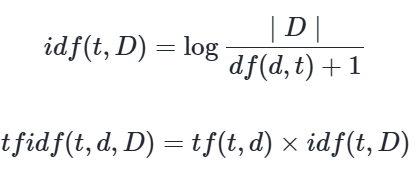

Word2Vec is a special case of the word embedding algorithms. 
<br>Using Word2Vec and similar models, we can not only vectorize words in a high-dimensional space (typically a few hundred dimensions) but also compare their semantic similarity.

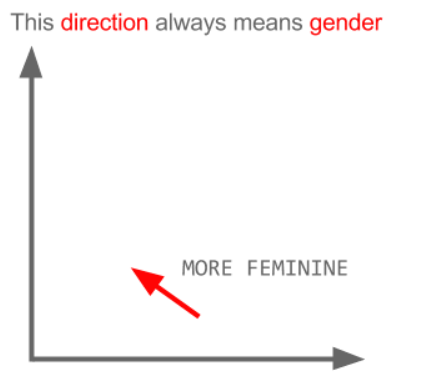

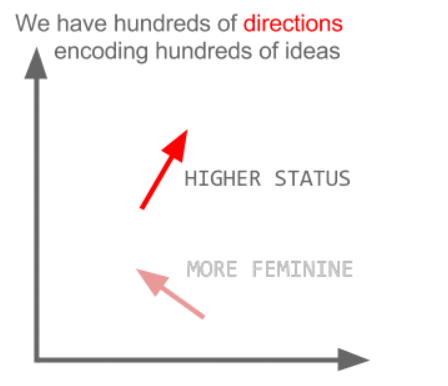

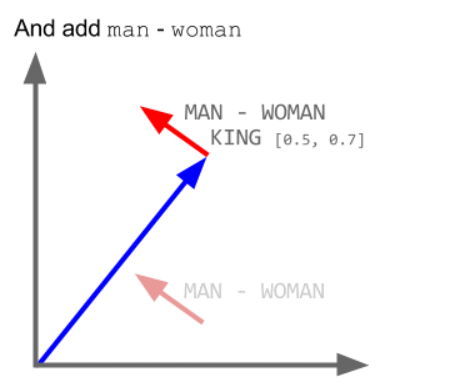

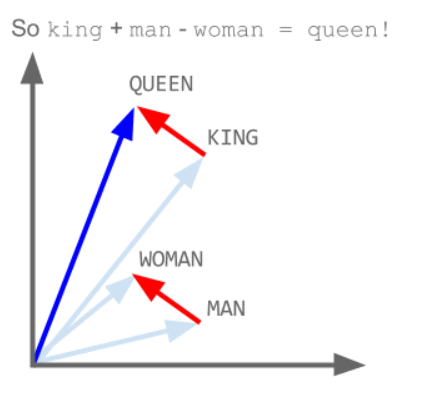

It is worth noting that this model does not comprehend the meaning of the words but simply tries to position the vectors such that words used in common context are close to each other. If this is not taken into account, a lot of fun examples will come up.

Such models need to be trained on very large datasets in order for the vector coordinates to capture the semantics.

<h3>Images<h3>

Often for problems associated with images, a convolutional neural network is used. You do not have to come up with the architecture and train a network from scratch. Instead, download a pretrained state-of-the-art network with the weights from public sources. Data scientists often do so-called fine-tuning to adapt these networks to their needs by “detaching” the last fully connected layers of the network, adding new layers chosen for a specific task, and then training the network on new data.

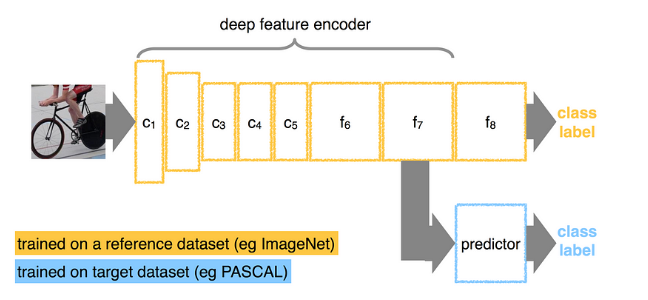

```python
import pytesseract
from PIL import Image
import requests
from io import BytesIO

##### Just a random picture from search
img = "http://ohscurrent.org/wp-content/uploads/2015/09/domus-01-google.jpg"
img = requests.get(img)
img = Image.open(BytesIO(img.content))
text = pytesseract.image_to_string(img)

print(text)

Google

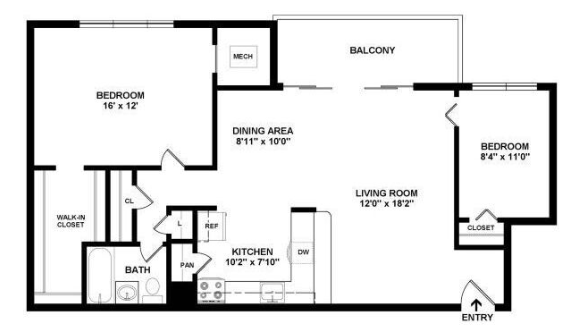

```python
img = "https://habrastorage.org/webt/mj/uv/6o/mjuv6olsh1x9xxe1a6zjy79u1w8.jpeg"
img = requests.get(img)
img = Image.open(BytesIO(img.content))

print(pytesseract.image_to_string(img))

‘BEDROOM
1exI2

DINING AREA
11" 100"

uvinc Room
120" 182"

KITCHEN
102" x T10"

x1t0"

<h3>Date and time<h3>

In [17]:
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

Dealing with hour (minute, day of the month …) is not as simple as it seems. If you use the hour as a real variable, we slightly contradict the nature of data: 0<23 while 0:00:00 02.01> 01.01 23:00:00. For some problems, this can be critical. At the same time, if you encode them as categorical variables, you’ll breed a large numbers of features and lose information about proximity – the difference between 22 and 23 will be the same as the difference between 22 and 7.

In [18]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [19]:
from scipy.spatial import distance

euclidean(make_harmonic_features(23), make_harmonic_features(1))

0.5176380902050424

In [20]:
euclidean(make_harmonic_features(9), make_harmonic_features(11))

0.5176380902050414

In [21]:
euclidean(make_harmonic_features(9), make_harmonic_features(21))

2.0000000000000004

<h3>Feature transformations<h3>

<h4>Normalization and changing distribution<h4>

Monotonic feature transformation is critical for some algorithms and has no effect on others. This is one of the reasons for the increased popularity of decision trees and all its derivative algorithms (random forest, gradient boosting). Not everyone can or want to tinker with transformations, and these algorithms are robust to unusual distributions.

However, data requirements are imposed not only by parametric methods; K nearest neighbors will predict complete nonsense if features are not normalized e.g. when one distribution is located in the vicinity of zero and does not go beyond (-1, 1) while the other’s range is on the order of hundreds of thousands.

A simple example: suppose that the task is to predict the cost of an apartment from two variables — the distance from city center and the number of rooms. The number of rooms rarely exceeds 5 whereas the distance from city center can easily be in the thousands of meters.

The simplest transformation is Standard Scaling (or Z-score normalization):

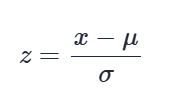

In [22]:
import numpy as np
from scipy.stats import beta, shapiro
from sklearn.preprocessing import StandardScaler

data = beta(1, 10).rvs(1000).reshape(-1, 1)
shapiro(data)

ShapiroResult(statistic=0.8702701926231384, pvalue=5.311747045946565e-28)

In [23]:
# Value of the statistic, p-value
shapiro(StandardScaler().fit_transform(data))

# With such p-value we'd have to reject the null hypothesis of normality of the data

ShapiroResult(statistic=0.8702701926231384, pvalue=5.311747045946565e-28)

In [24]:
data = np.array([1, 1, 0, -1, 2, 1, 2, 3, -2, 4, 100]).reshape(-1, 1).astype(np.float64)
StandardScaler().fit_transform(data)

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

In [25]:
(data - data.mean()) / data.std()

array([[-0.31922662],
       [-0.31922662],
       [-0.35434155],
       [-0.38945648],
       [-0.28411169],
       [-0.31922662],
       [-0.28411169],
       [-0.24899676],
       [-0.42457141],
       [-0.21388184],
       [ 3.15715128]])

Another fairly popular option is MinMax Scaling, which brings all the points within a predetermined interval (typically (0, 1)).

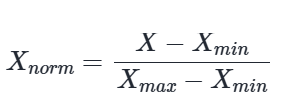

In [26]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler().fit_transform(data)

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

In [27]:
(data - data.min()) / (data.max() - data.min())

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.02941176],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]])

If we assume that some data is not normally distributed but is described by the log-normal distribution, it can easily be transformed to a normal distribution:

In [28]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
shapiro(data)

ShapiroResult(statistic=0.341294527053833, pvalue=0.0)

In [29]:
shapiro(np.log(data))

ShapiroResult(statistic=0.9961192607879639, pvalue=0.013325351290404797)

The lognormal distribution is suitable for describing salaries, price of securities, urban population, number of comments on articles on the internet, etc. However, to apply this procedure, the underlying distribution does not necessarily have to be lognormal; you can try to apply this transformation to any distribution with a heavy right tail.

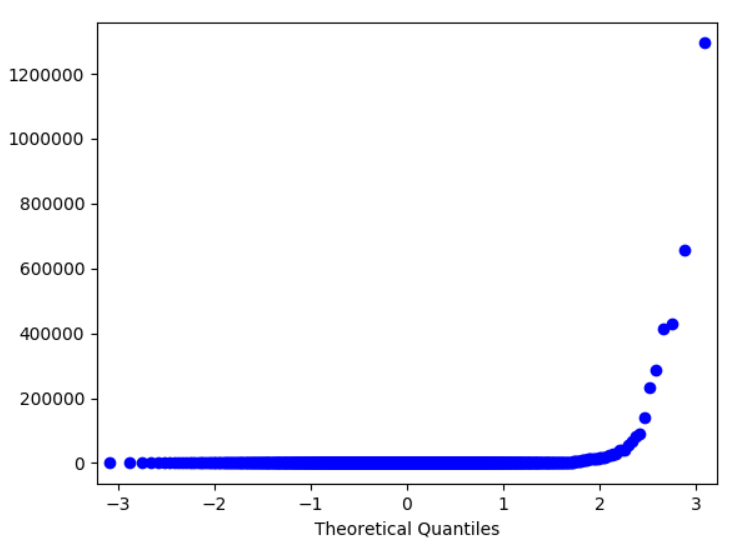

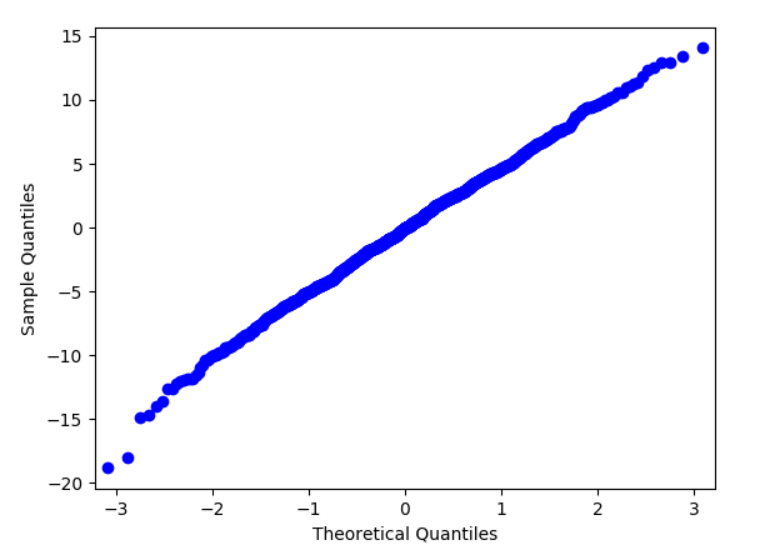

In [30]:
import statsmodels.api as sm

# Let's take the price feature from Renthop dataset and filter by hands the most extreme values for clarity

price = df.price[(df.price <= 20000) & (df.price > 500)]
price_log = np.log(price)

# A lot of gestures so that sklearn didn't shower us with warnings
price_mm = (
    MinMaxScaler()
    .fit_transform(price.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)
price_z = (
    StandardScaler()
    .fit_transform(price.values.reshape(-1, 1).astype(np.float64))
    .flatten()
)

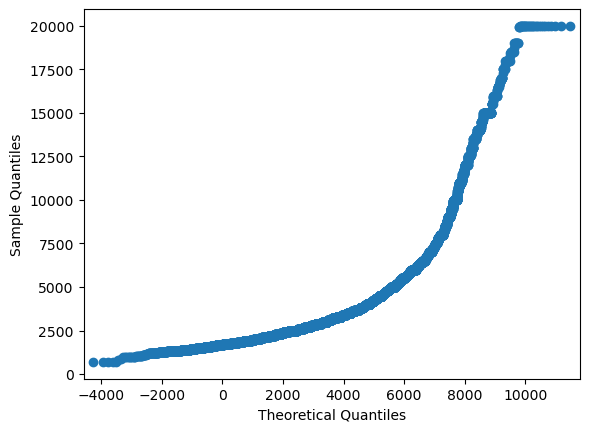

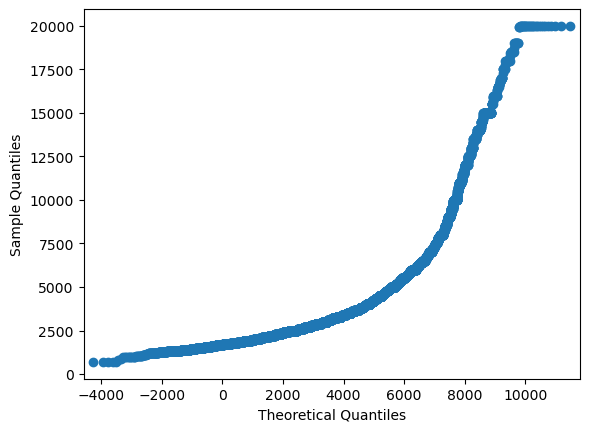

In [31]:
sm.qqplot(price, loc=price.mean(), scale=price.std())

Q-Q plot after StandardScaler. Shape doesn’t change:

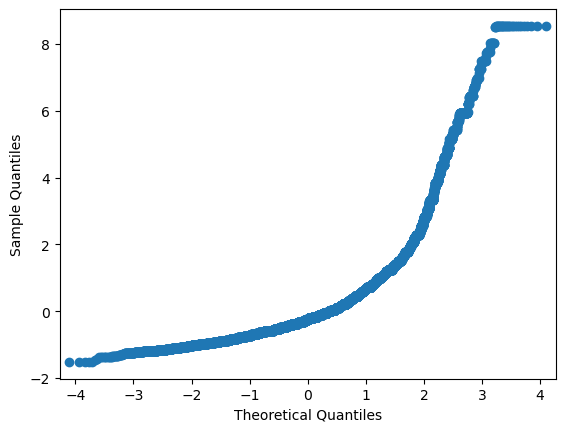

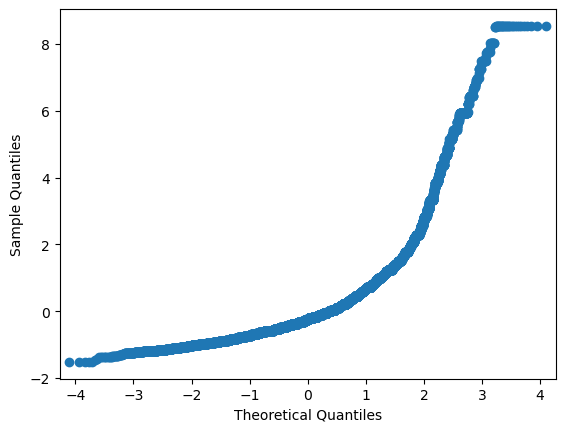

In [32]:
sm.qqplot(price_z, loc=price_z.mean(), scale=price_z.std())

Q-Q plot after MinMaxScaler. Shape doesn’t change:

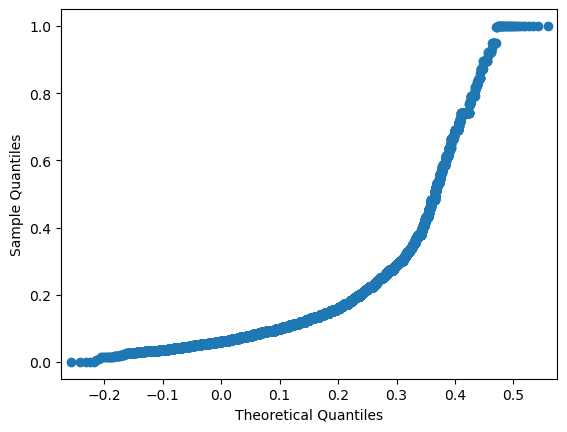

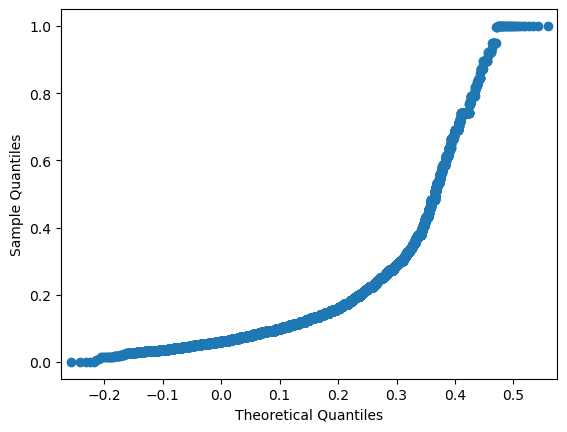

In [33]:
sm.qqplot(price_mm, loc=price_mm.mean(), scale=price_mm.std())


Q-Q plot after taking the logarithm. Things are getting better!

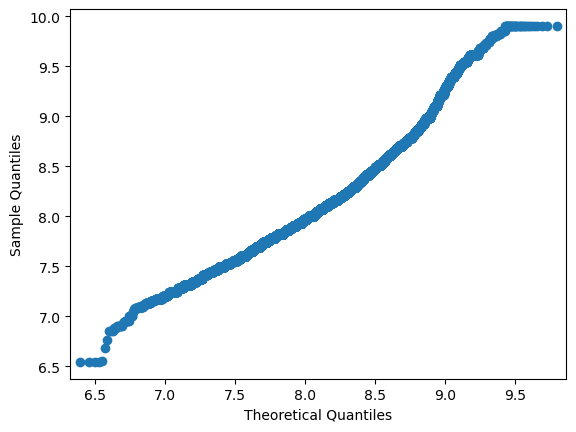

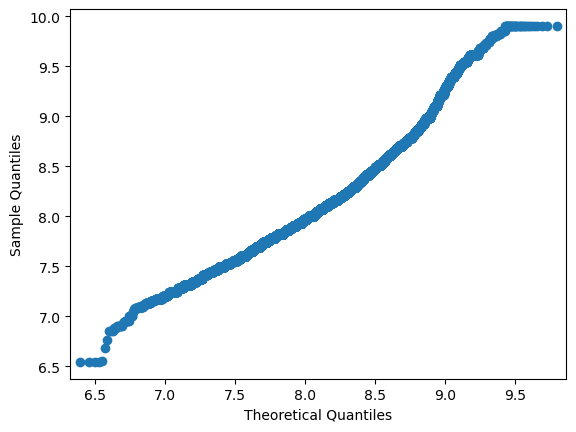

In [34]:
sm.qqplot(price_log, loc=price_log.mean(), scale=price_log.std())

<h3>Feature selection<h3>

The most obvious candidate for removal is a feature whose value remains unchanged, i.e., it contains no information at all. If we build on this thought, it is reasonable to say that features with low variance are worse than those with high variance. So, one can consider cutting features with variance below a certain threshold.

In [35]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import VarianceThreshold

x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [36]:
VarianceThreshold(0.7).fit_transform(x_data_generated).shape

(100, 19)

In [37]:
VarianceThreshold(0.8).fit_transform(x_data_generated).shape

(100, 16)

In [38]:
VarianceThreshold(0.9).fit_transform(x_data_generated).shape

(100, 11)

In [39]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(
    x_data_generated, y_data_generated
)
x_data_varth = VarianceThreshold(0.9).fit_transform(x_data_generated)

In [40]:
logit = LogisticRegression(solver="lbfgs", random_state=17)

In [41]:
cross_val_score(
    logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.521444455599719

In [42]:
cross_val_score(
    logit, x_data_kbest, y_data_generated, scoring="neg_log_loss", cv=5
).mean()

-0.4130388365825361

<h4>Selection by modeling<h4>

Another approach is to use some baseline model for feature evaluation because the model will clearly show the importance of the features. Two types of models are usually used: some “wooden” composition such as Random Forest or a linear model with Lasso regularization so that it is prone to nullify weights of weak features. The logic is intuitive: if features are clearly useless in a simple model, there is no need to drag them to a more complex one.

In [49]:
# Synthetic example

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

x_data_generated, y_data_generated = make_classification()

rf = RandomForestClassifier(n_estimators=10, random_state=17)
pipe = make_pipeline(SelectFromModel(estimator=rf), logit)

print(
    cross_val_score(
        logit, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        rf, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)
print(
    cross_val_score(
        pipe, x_data_generated, y_data_generated, scoring="neg_log_loss", cv=5
    ).mean()
)

-0.38295486822702274
-0.6526524129966602
-0.3031399467116704


In [50]:
# x_data, y_data = get_data()
x_data = x_data_generated
y_data = y_data_generated

pipe1 = make_pipeline(StandardScaler(), SelectFromModel(estimator=rf), logit)

pipe2 = make_pipeline(StandardScaler(), logit)

print(
    "LR + selection: ",
    cross_val_score(pipe1, x_data, y_data, scoring="neg_log_loss", cv=5).mean(),
)
print(
    "LR: ", cross_val_score(pipe2, x_data, y_data, scoring="neg_log_loss", cv=5).mean()
)
print("RF: ", cross_val_score(rf, x_data, y_data, scoring="neg_log_loss", cv=5).mean())

LR + selection:  -0.30820810539271226
LR:  -0.3725252319286906
RF:  -0.6526524129966602


<h3>Grid search<h3>

Finally, we get to the most reliable method, which is also the most computationally complex: trivial grid search. Train a model on a subset of features, store results, repeat for different subsets, and compare the quality of models to identify the best feature set. This approach is called Exhaustive Feature Selection.

Searching all combinations usually takes too long, so you can try to reduce the search space. Fix a small number N, iterate through all combinations of N features, choose the best combination, and then iterate through the combinations of (N + 1) features so that the previous best combination of features is fixed and only a single new feature is considered. It is possible to iterate until we hit a maximum number of characteristics or until the quality of the model ceases to increase significantly. This algorithm is called Sequential Feature Selection.

This algorithm can be reversed: start with the complete feature space and remove features one by one until it does not impair the quality of the model or until the desired number of features is reached.